##  NCSU Tropical and Large Scale Dynamics

### A. Aiyyer, Sep 2022

- Reads GRIDSAR CDR IR data from ncei 
- Plots a map 
- Calculates the area occupied by clouds below a user specified threshold


In [204]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import urllib
import tempfile
import geocat.viz.util as gvutil
import geocat.viz as gv

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import numpy as np
from metpy.plots import colortables



## Read the gridsat data from the NCEI URL for a user specified date

In [174]:
date = '2022.08.01.01.00'
url = "https://www.ncei.noaa.gov/thredds/fileServer/cdr/gridsat/2021/GRIDSAT-B1.2021.01.01.00.v02r01.nc"
mytfile = tempfile.NamedTemporaryFile()
urllib.request.urlretrieve(url, mytfile.name)
ds = xr.open_dataset(mytfile.name)

In [175]:
# set a temperature threshold to use to denote deep convective clouds
# 

In [176]:

Temp_threshold = -40. + 273. # cloud top temp. in Kelvin


(array([   3376.,   24623.,   59710.,   88747.,  114362.,  164910.,
         221648.,  470997., 1774000.,   14280.]),
 array([182.69   , 195.52   , 208.35   , 221.18   , 234.01   , 246.84   ,
        259.66998, 272.5    , 285.33   , 298.16   , 310.99   ],
       dtype=float32),
 <BarContainer object of 10 artists>)

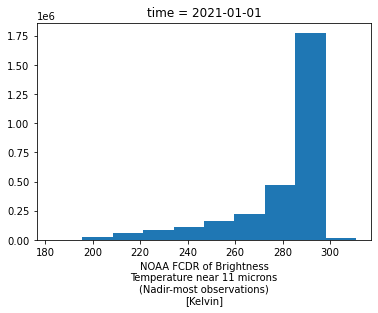

In [201]:
# domain for data extraction and map

min_lon = -180
max_lon =  180
cenLon = .5*(min_lon + max_lon)
min_lat =   -20
max_lat =  20

# set the min and max values to shade in the IR brightness temperature field
Cmin=  200
Cmax = 300
Cint = 10.

LatIndexer, LonIndexer = 'lat', 'lon'
irwin = ds.irwin_cdr[0,:,:].sel(**{LatIndexer: slice(min_lat, max_lat),
                        LonIndexer: slice(min_lon, max_lon)})
lats = irwin['lat'][:]
lons = irwin['lon'][:]

# a quick histogram of the data
xr.plot.hist(irwin)



# Plot the IR temperature data

[None, None]

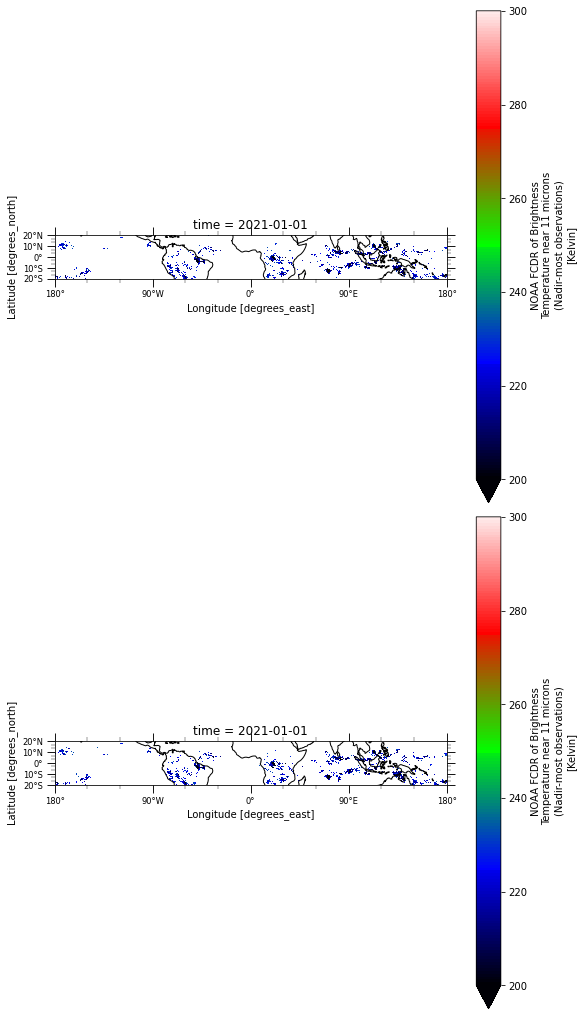

In [213]:
cmap = colortables.get_colortable('ir_tv1')



projection = ccrs.PlateCarree()
fig, ax = plt.subplots(2,
                       1,
                       constrained_layout=True,
                       subplot_kw={"projection": projection})

# Set figure size (width, height) in inches
fig.set_size_inches((8,14))

# Add continents
continents = cfeature.NaturalEarthFeature(name="coastline",
                                                 category="physical",
                                                 scale="110m",
                                                 edgecolor="black",
                                                 facecolor="None")
[axes.add_feature(continents) for axes in ax.flat]


# first plot the irwin data without threshold applied

ct = xr.plot.pcolormesh(irwin, rasterized=True, vmin=Cmin, vmax =Cmax, shading='flat', cmap=cmap, ax=ax[0])



# Now set all IR TB values Abvove the threshold to be NaN
irwin = irwin.where( irwin <=  Temp_threshold)



ct = xr.plot.pcolormesh(irwin, rasterized=True, vmin=Cmin, vmax =Cmax, shading='flat', cmap=cmap,ax=ax[1])



# Use geocat.viz.util convenience function to set axes limit
gvutil.set_axes_limits_and_ticks(ax[0],
                                xlim=(min_lon, max_lon),
                                ylim=(min_lat, max_lat),
                                xticks=np.linspace(min_lon,max_lon, 5),
                                yticks=np.linspace(min_lat,max_lat, 5))



# Use geocat.viz.util convenience function to set axes limit
gvutil.set_axes_limits_and_ticks(ax[1],
                                xlim=(min_lon, max_lon),
                                ylim=(min_lat, max_lat),
                                xticks=np.linspace(min_lon,max_lon, 5),
                                yticks=np.linspace(min_lat,max_lat, 5))


# Use geocat.viz.util convenience function to add minor and major tick lines
[gv.add_major_minor_ticks(axes) for axes in ax.flat]

# Use geocat.viz.util convenience function to make plots look like NCL plots by using latitude, longitude tick labels
[gv.add_lat_lon_ticklabels(axes) for axes in ax.flat]

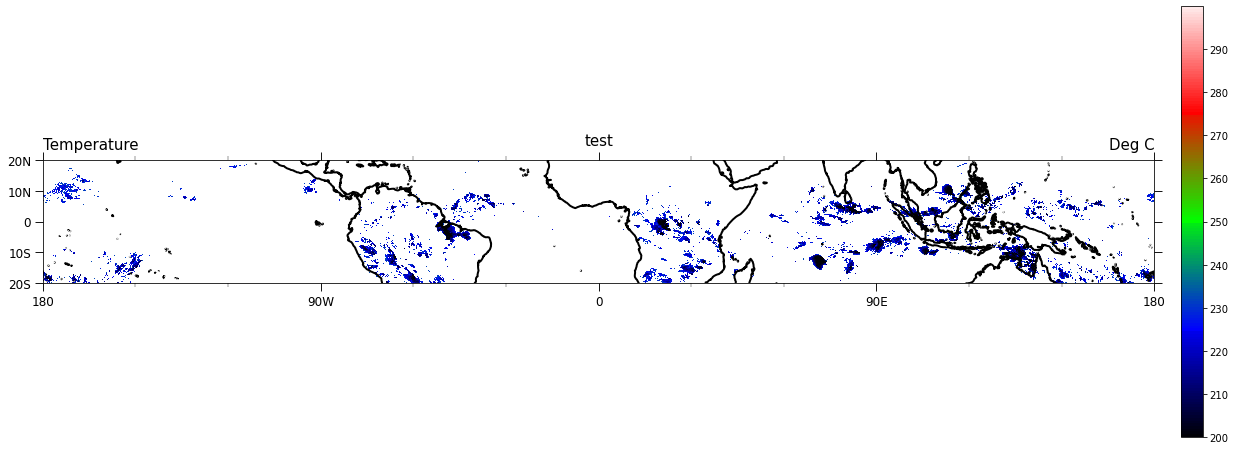

In [214]:
fig = plt.figure(figsize=(24,8))

# Generate axes, using Cartopy, drawing coastlines, and adding features
projection = ccrs.PlateCarree()    
ax = plt.axes(projection=projection)
ax.coastlines(linewidths=2., color='black')
# drop the last row and column to be compatible with shading=flat. see documentation for pcolormesh
ct = plt.pcolormesh(lons, lats, irwin[:-1,:-1], rasterized=True, vmin=Cmin, vmax =Cmax, shading='flat')
#ct = plt.imshow(irwin[:-1,:-1], cmap='Greys', origin='lower', extent=[min_lon, max_lon,min_lat, max_lat])

# assign a color map from some metpy predefined color maps
cmap = colortables.get_colortable('ir_tv1')
ct.set_cmap(cmap)

# Use geocat.viz.util convenience function to add major tick lines
gvutil.add_major_minor_ticks(ax, y_minor_per_major=1, labelsize=12)

# Use geocat.viz.util convenience function to add lat and lon tick labels
gvutil.add_lat_lon_ticklabels(ax)

# Remove degree symbol from tick label
ax.yaxis.set_major_formatter(LatitudeFormatter(degree_symbol=''))
ax.xaxis.set_major_formatter(LongitudeFormatter(degree_symbol=''))
# Use geocat.viz.util convenience function to set titles and labels


# Use geocat.viz.util convenience function to set axes limit
gvutil.set_axes_limits_and_ticks(ax,
                                xlim=(min_lon, max_lon),
                                ylim=(min_lat, max_lat),
                                xticks=np.linspace(min_lon,max_lon, 5),
                                yticks=np.linspace(min_lat,max_lat, 5))


gvutil.set_titles_and_labels(ax,
                                 righttitle="Deg C",
                                 righttitlefontsize=15,
                                 lefttitle="Temperature",
                                 lefttitlefontsize=15,
                                 xlabel="",
                                 ylabel="")

# Add color bar
cbar_ticks = np.arange(Cmin,Cmax,Cint)
cbar = plt.colorbar(ct,
                    orientation='vertical',
                    shrink=0.99,
                    pad=0.02,
                    extendrect=True,
                    ticks=cbar_ticks)

cbar.ax.tick_params(labelsize=10)  

title='test'
plt.title(title, x=.5, y=1.07, fontsize=15)
plt.show()

In [77]:
# calculate the area of each grid cell

In [165]:
dlat = np.deg2rad(irwin.lat[1] - irwin.lat[0])
dlon = np.deg2rad(irwin.lon[1] - irwin.lon[0])
weights = np.cos(np.deg2rad(irwin.lat))
R = 6378.137 # // Radius of earth in km

# expand the dimensions of weights to create a 2D array of latxlon
area = weights.expand_dims(lon = irwin.lon, axis=1)*R*R*dlat*dlon

In [169]:
areaTot  = area.sum()
mask = irwin.where(irwin <= Temp_threshold)
areaThreshold = area.where(irwin <= Temp_threshold).sum()
fraction = 100.*areaThreshold/areaTot
fraction.values

array(5.76500458)